In [1]:
from collections import defaultdict
from datetime import datetime, date, time, timedelta
import json
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

sns.set_theme()
plt.style.use('Solarize_Light2')

In [2]:
ALL_IDS = pd.read_csv('identifications.csv')
ALL_IDS.insert(3, 'datetime', pd.to_datetime(ALL_IDS['date']))

standard_times = ALL_IDS['datetime'].apply(lambda x: (x - x.utcoffset()).replace(tzinfo=None))
ALL_IDS['datetime'] = standard_times
ALL_IDS['date'] = standard_times.apply(lambda x: x.date())
ALL_IDS.insert(5, 'time', standard_times.apply(lambda x: x.time()))

ALL_IDS.sort_values(by='date', inplace=True)
ALL_IDS

,observation,identifier,username,datetime,date,time,taxon_id,taxon,rank,rank_level,previous_taxon_id,current,disagreement,category,vision,hidden
7,5607,357,annetanne,2010-02-19 09:26:16,2010-02-19,09:26:16,51702,Coccinella septempunctata,species,10,NaN,True,NaN,improving,False,False
10,5783,308,triplep220,2010-02-28 08:37:33,2010-02-28,08:37:33,48486,Coccinellidae,family,30,NaN,True,NaN,supporting,False,False
18,12381,477,loarie,2011-03-07 07:24:46,2011-03-07,07:24:46,48486,Coccinellidae,family,30,NaN,True,NaN,improving,False,False
33,18740,642,biosam,2011-05-29 18:14:10,2011-05-29,18:14:10,48486,Coccinellidae,family,30,NaN,True,NaN,improving,False,False
36,18741,642,biosam,2011-05-29 18:29:36,2011-05-29,18:29:36,48486,Coccinellidae,family,30,NaN,True,NaN,improving,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195459,45832768,1485790,cpu,2022-11-25 21:29:59,2022-11-25,21:29:59,243969,Exochomus,genus,20,48486.0,True,False,supporting,False,False
234700,55597317,1485790,cpu,2022-11-25 21:59:43,2022-11-25,21:59:43,354547,Chilocorinae,subfamily,27,48486.0,True,False,leading,False,False
195492,45837008,1485790,cpu,2022-11-25 21:44:08,2022-11-25,21:44:08,207617,Coccinella trifasciata subversa,subspecies,5,48486.0,True,False,leading,False,False
194938,45710125,1485790,cpu,2022-11-25 22:10:48,2022-11-25,22:10:48,207617,Coccinella trifasciata subversa,subspecies,5,207617.0,True,False,supporting,False,False


In [3]:
USER_TOTALS = pd.read_csv('stats.csv', index_col='identifier')
USER_TOTALS

,username,total,frac_species,species,frac_genus,genus,frac_tribe,tribe,frac_subfamily,subfamily,frac_family,family
identifier,,,,,,,,,,,,
463097,richyfourtytwo,65109,0.858990,55928,0.045600,2969,0.087914,5724,0.000415,27,0.007080,461
1442162,rob-westerduijn,37487,0.996932,37372,0.001334,50,0.000080,3,0.001147,43,0.000507,19
2116455,davidenrique,19244,0.990802,19067,0.005560,107,0.000104,2,0.000156,3,0.003378,65
1012326,dusty_in_vilas-tx,14508,0.966157,14017,0.023642,343,0.003377,49,0.004825,70,0.001999,29
2249019,elytrid,12954,0.964181,12490,0.006330,82,0.017910,232,0.002393,31,0.009186,119
...,...,...,...,...,...,...,...,...,...,...,...,...
111602,laurenis4animals,1,1.000000,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0
1685053,pixie2sneakers,1,1.000000,1,0.000000,0,0.000000,0,0.000000,0,0.000000,0
24133,carrielynn,1,0.000000,0,1.000000,1,0.000000,0,0.000000,0,0.000000,0


In [4]:
# how many IDs are there in total? how many/what percent are by the top 50 identifiers?

TOP_50_USERS = ALL_IDS[ALL_IDS['identifier'].isin(USER_TOTALS.index[:50])]

print(f"{len(ALL_IDS)} total IDs")
print(f"{len(TOP_50_USERS)} IDs by top 50 identifiers ({int(len(TOP_50_USERS)/len(ALL_IDS)*100)}%)")

426528 total IDs
284274 IDs by top 50 identifiers (66%)


In [5]:
SESSIONS_BY_TOP_50 = defaultdict(list)

for ident, idgroup in TOP_50_USERS.groupby('identifier'):
    for day, daygroup in idgroup.groupby('date'):
        print(ident, "-", day, "-", len(daygroup))
        SESSIONS_BY_TOP_50[ident].append(daygroup)

6971 - 2015-03-28 - 5
6971 - 2015-03-29 - 1
6971 - 2015-04-03 - 1
6971 - 2015-04-05 - 1
6971 - 2015-04-06 - 43
6971 - 2015-04-07 - 2
6971 - 2015-04-08 - 3
6971 - 2015-04-12 - 2
6971 - 2015-04-13 - 2
6971 - 2015-04-15 - 5
6971 - 2015-04-16 - 3
6971 - 2015-04-18 - 1
6971 - 2015-04-19 - 3
6971 - 2015-04-21 - 1
6971 - 2015-04-22 - 1
6971 - 2015-04-26 - 1
6971 - 2015-04-29 - 2
6971 - 2015-05-01 - 3
6971 - 2015-05-02 - 2
6971 - 2015-05-03 - 1
6971 - 2015-05-07 - 1
6971 - 2015-05-11 - 8
6971 - 2015-05-15 - 1
6971 - 2015-05-16 - 4
6971 - 2015-05-17 - 2
6971 - 2015-05-23 - 1
6971 - 2015-05-24 - 4
6971 - 2015-05-25 - 1
6971 - 2015-05-27 - 1
6971 - 2015-05-30 - 10
6971 - 2015-06-01 - 1
6971 - 2015-06-02 - 2
6971 - 2015-06-03 - 3
6971 - 2015-06-05 - 1
6971 - 2015-06-06 - 1
6971 - 2015-06-09 - 1
6971 - 2015-06-10 - 1
6971 - 2015-06-11 - 1
6971 - 2015-06-12 - 2
6971 - 2015-06-16 - 1
6971 - 2015-06-17 - 2
6971 - 2015-06-20 - 1
6971 - 2015-06-21 - 2
6971 - 2015-06-26 - 2
6971 - 2015-07-01 - 3
6971 - 2

52839 - 2015-06-01 - 1
52839 - 2015-06-06 - 1
52839 - 2015-06-08 - 1
52839 - 2015-06-17 - 3
52839 - 2015-06-18 - 1
52839 - 2015-06-20 - 1
52839 - 2015-06-21 - 1
52839 - 2015-06-27 - 1
52839 - 2015-06-29 - 1
52839 - 2015-06-30 - 5
52839 - 2015-07-03 - 1
52839 - 2015-07-09 - 1
52839 - 2015-07-12 - 1
52839 - 2015-07-13 - 2
52839 - 2015-07-14 - 2
52839 - 2015-07-16 - 2
52839 - 2015-07-27 - 1
52839 - 2015-07-28 - 1
52839 - 2015-08-12 - 1
52839 - 2015-08-21 - 6
52839 - 2015-08-23 - 3
52839 - 2015-08-25 - 1
52839 - 2015-08-30 - 1
52839 - 2015-09-03 - 1
52839 - 2015-09-04 - 1
52839 - 2015-09-06 - 2
52839 - 2015-09-19 - 1
52839 - 2015-09-24 - 1
52839 - 2015-09-27 - 1
52839 - 2015-10-01 - 10
52839 - 2015-10-03 - 1
52839 - 2015-10-04 - 1
52839 - 2015-10-05 - 1
52839 - 2015-10-06 - 8
52839 - 2015-10-12 - 42
52839 - 2015-10-18 - 2
52839 - 2015-10-20 - 2
52839 - 2015-10-29 - 2
52839 - 2015-10-31 - 3
52839 - 2015-11-01 - 1
52839 - 2015-11-02 - 4
52839 - 2015-11-03 - 2
52839 - 2015-11-06 - 2
52839 - 2

115129 - 2020-05-27 - 22
115129 - 2020-05-28 - 128
115129 - 2020-05-29 - 7
115129 - 2020-05-30 - 1
115129 - 2020-05-31 - 1
115129 - 2020-06-03 - 2
115129 - 2020-06-12 - 1
115129 - 2020-06-16 - 1
115129 - 2020-06-19 - 1
115129 - 2020-06-23 - 1
115129 - 2020-07-02 - 1
115129 - 2020-07-05 - 1
115129 - 2020-07-06 - 3
115129 - 2020-07-07 - 1
115129 - 2020-07-14 - 1
115129 - 2020-07-15 - 1
115129 - 2020-07-16 - 1
115129 - 2020-07-18 - 1
115129 - 2020-07-19 - 1
115129 - 2020-07-21 - 1
115129 - 2020-07-24 - 1
115129 - 2020-07-29 - 1
115129 - 2020-07-31 - 3
115129 - 2020-08-02 - 17
115129 - 2020-08-03 - 1
115129 - 2020-08-04 - 14
115129 - 2020-08-05 - 1
115129 - 2020-08-07 - 3
115129 - 2020-08-09 - 2
115129 - 2020-08-10 - 16
115129 - 2020-08-11 - 2
115129 - 2020-08-12 - 1
115129 - 2020-08-15 - 1
115129 - 2020-08-16 - 4
115129 - 2020-08-20 - 5
115129 - 2020-08-21 - 1
115129 - 2020-08-22 - 1
115129 - 2020-08-23 - 1
115129 - 2020-08-24 - 2
115129 - 2020-08-25 - 1
115129 - 2020-08-27 - 4
115129 - 2

180811 - 2021-07-03 - 1
180811 - 2021-07-04 - 4
180811 - 2021-07-05 - 2
180811 - 2021-07-06 - 3
180811 - 2021-07-07 - 1
180811 - 2021-07-08 - 4
180811 - 2021-07-09 - 2
180811 - 2021-07-10 - 8
180811 - 2021-07-12 - 5
180811 - 2021-07-13 - 1
180811 - 2021-07-15 - 3
180811 - 2021-07-17 - 2
180811 - 2021-07-22 - 3
180811 - 2021-07-24 - 2
180811 - 2021-07-25 - 2
180811 - 2021-07-26 - 1
180811 - 2021-07-27 - 1
180811 - 2021-07-30 - 2
180811 - 2021-07-31 - 1
180811 - 2021-08-02 - 2
180811 - 2021-08-04 - 3
180811 - 2021-08-05 - 4
180811 - 2021-08-06 - 3
180811 - 2021-08-08 - 6
180811 - 2021-08-09 - 8
180811 - 2021-08-12 - 3
180811 - 2021-08-13 - 1
180811 - 2021-08-17 - 1
180811 - 2021-08-20 - 31
180811 - 2021-08-21 - 3
180811 - 2021-08-24 - 1
180811 - 2021-08-25 - 1
180811 - 2021-08-26 - 4
180811 - 2021-08-27 - 18
180811 - 2021-09-01 - 7
180811 - 2021-09-02 - 6
180811 - 2021-09-04 - 4
180811 - 2021-09-05 - 3
180811 - 2021-09-07 - 3
180811 - 2021-09-08 - 6
180811 - 2021-09-09 - 2
180811 - 2021-

463097 - 2017-04-26 - 1
463097 - 2017-04-27 - 1
463097 - 2017-04-28 - 1
463097 - 2017-04-30 - 3
463097 - 2017-05-01 - 1
463097 - 2017-05-03 - 5
463097 - 2017-05-04 - 1
463097 - 2017-05-05 - 10
463097 - 2017-05-07 - 5
463097 - 2017-05-08 - 1
463097 - 2017-05-09 - 1
463097 - 2017-05-12 - 5
463097 - 2017-05-14 - 2
463097 - 2018-02-14 - 14
463097 - 2018-02-17 - 2
463097 - 2018-02-20 - 1
463097 - 2018-02-23 - 15
463097 - 2018-02-27 - 1
463097 - 2018-03-03 - 1
463097 - 2018-08-15 - 4
463097 - 2019-02-06 - 15
463097 - 2019-08-25 - 46
463097 - 2019-09-01 - 15
463097 - 2019-09-02 - 85
463097 - 2019-09-03 - 33
463097 - 2019-09-04 - 86
463097 - 2019-09-05 - 36
463097 - 2019-09-06 - 53
463097 - 2019-09-07 - 122
463097 - 2019-09-08 - 50
463097 - 2019-09-09 - 65
463097 - 2019-09-10 - 221
463097 - 2019-09-11 - 23
463097 - 2019-09-12 - 36
463097 - 2019-09-13 - 29
463097 - 2019-09-14 - 48
463097 - 2019-09-15 - 50
463097 - 2019-09-16 - 194
463097 - 2019-09-17 - 122
463097 - 2019-09-18 - 152
463097 - 201

579740 - 2018-12-24 - 4
579740 - 2018-12-25 - 3
579740 - 2018-12-26 - 10
579740 - 2018-12-27 - 3
579740 - 2018-12-28 - 5
579740 - 2018-12-29 - 3
579740 - 2018-12-30 - 6
579740 - 2018-12-31 - 7
579740 - 2019-01-01 - 9
579740 - 2019-01-02 - 61
579740 - 2019-01-03 - 5
579740 - 2019-01-04 - 3
579740 - 2019-01-05 - 2
579740 - 2019-01-19 - 5
579740 - 2019-01-20 - 1
579740 - 2019-01-21 - 5
579740 - 2019-01-22 - 11
579740 - 2019-01-23 - 2
579740 - 2019-01-24 - 1
579740 - 2019-01-25 - 545
579740 - 2019-01-26 - 3
579740 - 2019-01-27 - 3
579740 - 2019-01-28 - 2
579740 - 2019-01-29 - 6
579740 - 2019-01-30 - 3
579740 - 2019-01-31 - 9
579740 - 2019-02-01 - 1
579740 - 2019-02-04 - 3
579740 - 2019-02-05 - 4
579740 - 2019-02-06 - 6
579740 - 2019-02-07 - 3
579740 - 2019-02-09 - 3
579740 - 2019-02-10 - 10
579740 - 2019-02-11 - 6
579740 - 2019-02-12 - 8
579740 - 2019-02-13 - 8
579740 - 2019-02-14 - 9
579740 - 2019-02-15 - 92
579740 - 2019-02-16 - 4
579740 - 2019-02-17 - 5
579740 - 2019-02-18 - 7
579740 - 

1163777 - 2019-05-01 - 1
1163777 - 2019-05-09 - 1
1163777 - 2020-04-28 - 5
1163777 - 2020-05-01 - 4
1163777 - 2020-05-04 - 14
1163777 - 2020-05-05 - 3
1163777 - 2020-05-06 - 1
1163777 - 2020-05-07 - 1
1163777 - 2020-05-08 - 12
1163777 - 2020-05-09 - 2
1163777 - 2020-05-10 - 8
1163777 - 2020-05-11 - 16
1163777 - 2020-05-12 - 2
1163777 - 2020-05-14 - 5
1163777 - 2020-05-15 - 2
1163777 - 2020-05-16 - 4
1163777 - 2020-05-17 - 9
1163777 - 2020-05-18 - 1
1163777 - 2020-05-19 - 16
1163777 - 2020-05-20 - 94
1163777 - 2020-05-21 - 113
1163777 - 2020-05-22 - 55
1163777 - 2020-05-23 - 3
1163777 - 2020-05-24 - 45
1163777 - 2020-05-25 - 33
1163777 - 2020-05-26 - 10
1163777 - 2020-05-27 - 8
1163777 - 2020-05-28 - 10
1163777 - 2020-05-29 - 1
1163777 - 2020-05-30 - 7
1163777 - 2020-05-31 - 3
1163777 - 2020-06-01 - 7
1163777 - 2020-06-02 - 6
1163777 - 2020-06-03 - 1
1163777 - 2020-06-04 - 5
1163777 - 2020-06-05 - 5
1163777 - 2020-06-06 - 5
1163777 - 2020-06-07 - 2
1163777 - 2020-06-08 - 10
1163777 - 20

2032840 - 2022-08-02 - 27
2116455 - 2019-09-07 - 29
2116455 - 2019-09-12 - 1
2116455 - 2019-09-18 - 1
2116455 - 2019-09-27 - 1
2116455 - 2019-10-07 - 1
2116455 - 2019-10-08 - 1
2116455 - 2019-10-12 - 1
2116455 - 2019-10-20 - 1
2116455 - 2019-10-22 - 1
2116455 - 2019-10-25 - 2
2116455 - 2019-10-28 - 1
2116455 - 2019-11-02 - 1
2116455 - 2019-11-22 - 1
2116455 - 2019-11-30 - 1
2116455 - 2019-12-09 - 1
2116455 - 2019-12-21 - 7
2116455 - 2019-12-22 - 4
2116455 - 2019-12-23 - 2
2116455 - 2019-12-24 - 4
2116455 - 2019-12-25 - 3
2116455 - 2019-12-26 - 2
2116455 - 2019-12-27 - 2
2116455 - 2019-12-28 - 3
2116455 - 2019-12-31 - 1
2116455 - 2020-01-03 - 1
2116455 - 2020-01-05 - 1
2116455 - 2020-01-06 - 1
2116455 - 2020-01-08 - 1
2116455 - 2020-01-11 - 3
2116455 - 2020-01-12 - 1
2116455 - 2020-01-16 - 1
2116455 - 2020-01-18 - 1
2116455 - 2020-01-22 - 1
2116455 - 2020-01-23 - 2
2116455 - 2020-01-27 - 1
2116455 - 2020-02-01 - 10
2116455 - 2020-02-04 - 1
2116455 - 2020-02-05 - 1
2116455 - 2020-02-06 -

2249019 - 2019-09-16 - 1
2249019 - 2019-09-19 - 1
2249019 - 2019-09-21 - 1
2249019 - 2019-09-23 - 1
2249019 - 2019-09-25 - 1
2249019 - 2019-09-27 - 1
2249019 - 2019-10-04 - 2
2249019 - 2019-10-08 - 2
2249019 - 2019-10-14 - 2
2249019 - 2019-10-17 - 1
2249019 - 2019-10-18 - 3
2249019 - 2019-10-19 - 1
2249019 - 2019-10-21 - 5
2249019 - 2019-10-23 - 1
2249019 - 2019-10-25 - 3
2249019 - 2019-10-27 - 1
2249019 - 2019-10-28 - 5
2249019 - 2019-10-30 - 11
2249019 - 2019-10-31 - 1
2249019 - 2019-11-01 - 2
2249019 - 2019-11-02 - 12
2249019 - 2019-11-03 - 6
2249019 - 2019-11-04 - 1
2249019 - 2019-11-05 - 2
2249019 - 2019-11-06 - 4
2249019 - 2019-11-07 - 2
2249019 - 2019-11-08 - 5
2249019 - 2019-11-10 - 2
2249019 - 2019-11-11 - 3
2249019 - 2019-11-12 - 2
2249019 - 2019-11-13 - 5
2249019 - 2019-11-14 - 5
2249019 - 2019-11-15 - 3
2249019 - 2019-11-16 - 5
2249019 - 2019-11-17 - 7
2249019 - 2019-11-18 - 5
2249019 - 2019-11-19 - 4
2249019 - 2019-11-20 - 3
2249019 - 2019-11-21 - 6
2249019 - 2019-11-22 - 

In [6]:
def make_session_dots():
    vars = ['user', 'username', 'user_leaderboard', 'date', 'ids']
    SESSION_DOTS = pd.DataFrame(columns=vars)

    for user, userlist in SESSIONS_BY_TOP_50.items():
        for sesh_df in userlist:
            ranking = USER_TOTALS.index.get_loc(user)+1
            session = pd.DataFrame([[user, USER_TOTALS.loc[user, 'username'], ranking, sesh_df.iloc[0]['date'], len(sesh_df)]], columns=vars)
            SESSION_DOTS = pd.concat([SESSION_DOTS, session])
    SESSION_DOTS = SESSION_DOTS.sort_values('ids', ascending=False).reset_index(drop=True)
    SESSION_DOTS.index.rename('session_leaderboard', inplace=True)
    return SESSION_DOTS

SESSION_DOTS = make_session_dots()
# SESSION_DOTS.to_csv('sessions.csv')

# SESSION_DOTS = pd.read_csv('sessions.csv', parse_dates=['date'])

SESSION_DOTS.head()

,user,username,user_leaderboard,date,ids
session_leaderboard,,,,,
0,1485790,cpu,8,2021-12-02,2005
1,1442162,rob-westerduijn,2,2020-08-23,1209
2,1442162,rob-westerduijn,2,2020-06-21,1080
3,1442162,rob-westerduijn,2,2021-05-15,965
4,6971,silversea_starsong,6,2016-12-27,941


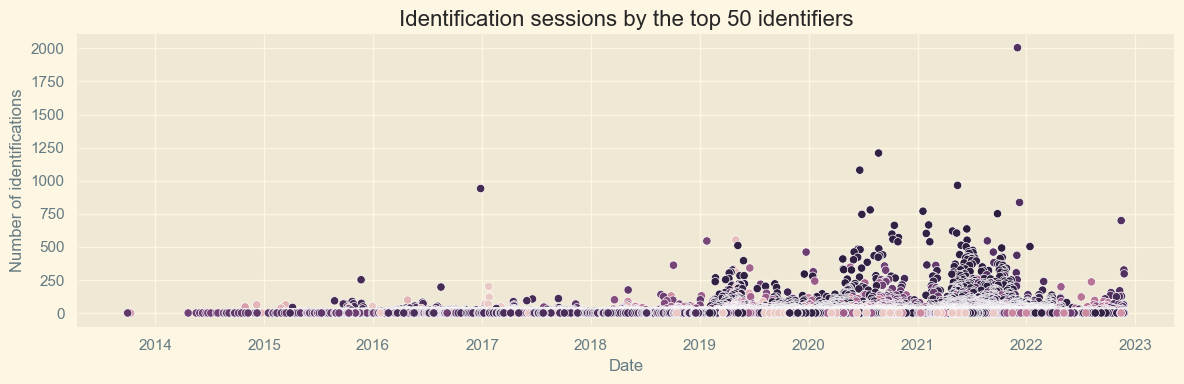

In [7]:
axes = sns.relplot(x=SESSION_DOTS['date'], y=SESSION_DOTS['ids'], hue=SESSION_DOTS['user_leaderboard'], 
                   height=4, aspect=3, 
                   palette=sns.cubehelix_palette(50, reverse=True), legend=False,
                   ).axes[0,0]
axes.set(title='Identification sessions by the top 50 identifiers', xlabel='Date', ylabel='Number of identifications')
axes.figure.tight_layout()
axes.figure.savefig('sessions by count.png')

So at this point we've sliced the original "IDs on observations labeled as Coccinellidae in NA & SA" down to:
- Identifications of "Coccinellidae" or below...
- ...by the top 50 such identifiers...
- ...grouped by date...
- ...where the identifier made at least 30 identifications on that day

Which leaves 1,669 sessions of however-many total IDs

1694 sessions total


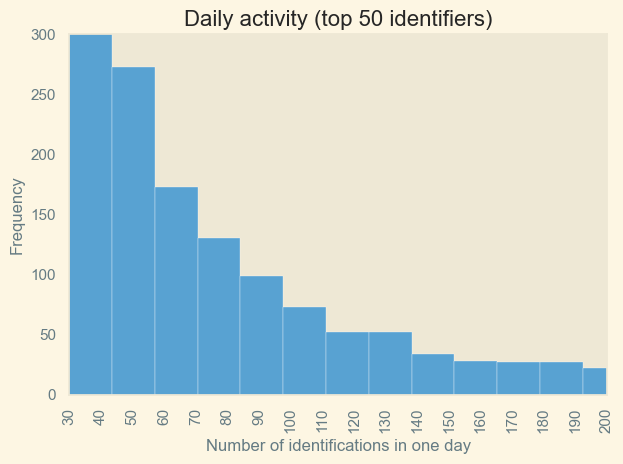

In [8]:
# each page in Identify shows 30 observations 
# = to do more than 30 IDs a user would have had to skim through multiple pages of results

SESSION_DOTS_SLICE = SESSION_DOTS[SESSION_DOTS['ids'] >= 30]
print(len(SESSION_DOTS_SLICE), "sessions total")

# plot the frequency of number of IDs in a single session (to work out where to cut off for session analysis)
ax = sns.histplot(data=SESSION_DOTS_SLICE, x='ids')
ax.set(title='Daily activity (top 50 identifiers)', xlabel='Number of identifications in one day', ylabel='Frequency',
       xlim=(30,200), xticks=(range(30,210,10)), ylim=(0,300))
plt.xticks(rotation=90)
ax.grid(False)
ax.figure.tight_layout()
ax
ax.figure.savefig('snapshot daily')

# Tracking the 20 most active identifiers over time

In [9]:
# want to look at date dots by identifier, for at least the top 20 identifiers
ALL_DATES_BY_TOP_20_USERS = SESSION_DOTS.loc[SESSION_DOTS.user.isin(USER_TOTALS.index[:20])]
ALL_DATES_BY_TOP_20_USERS = ALL_DATES_BY_TOP_20_USERS.sort_values(by='user_leaderboard')
ALL_DATES_BY_TOP_20_USERS

,user,username,user_leaderboard,date,ids
session_leaderboard,,,,,
9143,463097,richyfourtytwo,1,2022-04-20,4
1293,463097,richyfourtytwo,1,2021-12-24,40
1292,463097,richyfourtytwo,1,2020-02-13,40
3221,463097,richyfourtytwo,1,2020-01-22,14
566,463097,richyfourtytwo,1,2020-04-04,94
...,...,...,...,...,...
3078,1809393,jtkindt,20,2020-10-29,15
8582,1809393,jtkindt,20,2020-04-10,5
6973,1809393,jtkindt,20,2020-10-27,6


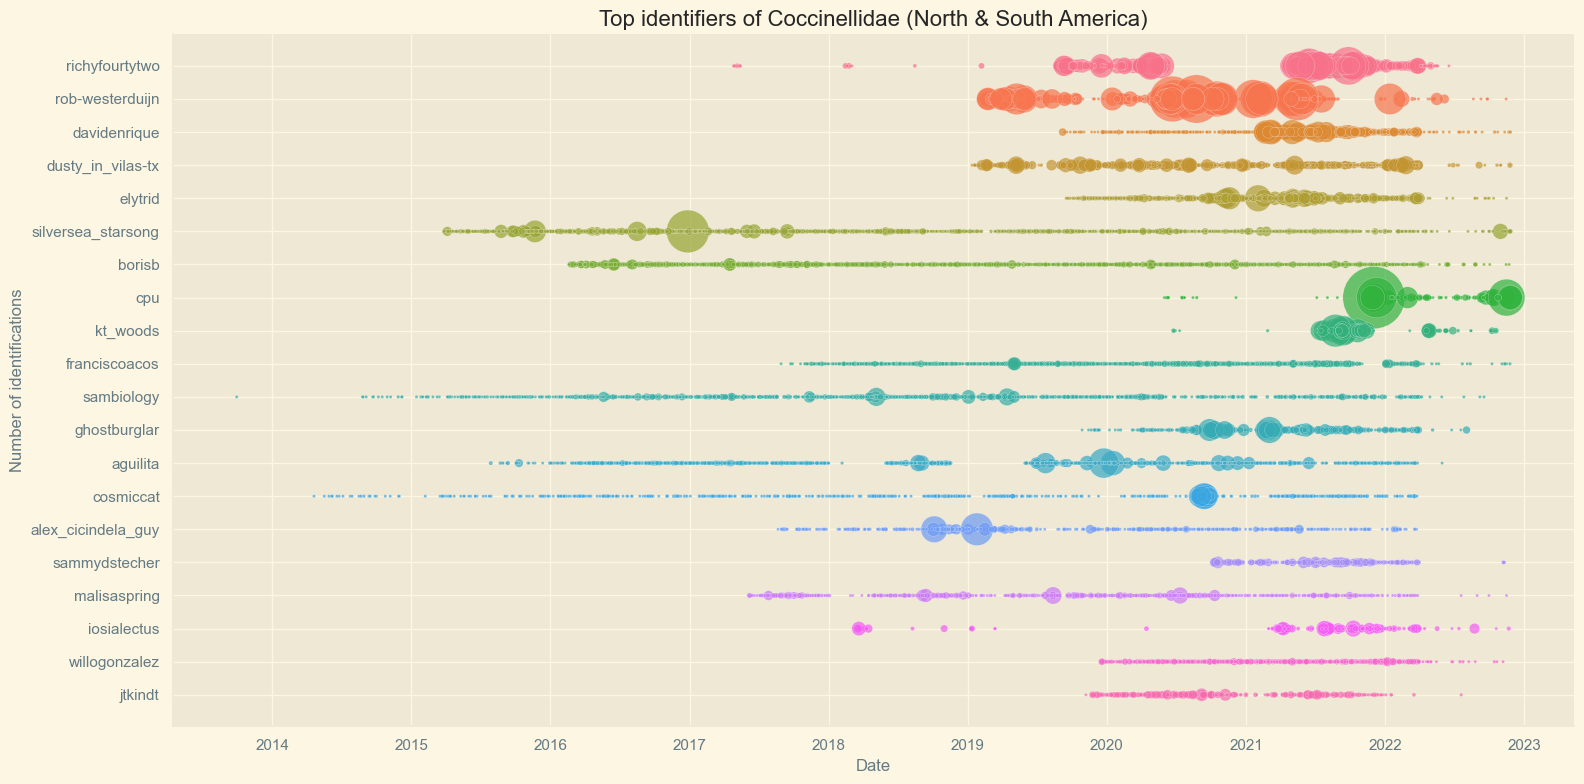

In [17]:
axes = sns.relplot(x=ALL_DATES_BY_TOP_20_USERS['date'], y=ALL_DATES_BY_TOP_20_USERS['username'], hue=ALL_DATES_BY_TOP_20_USERS['username'],
                   size=ALL_DATES_BY_TOP_20_USERS['ids'], sizes=(5,2000), alpha=.7, 
                   palette=sns.color_palette("husl", 20), legend=False, height=8, aspect=2
                   ).axes[0,0]
axes.set(title='Top identifiers of Coccinellidae (North & South America)', xlabel='Date', ylabel='Number of identifications')
axes.figure.tight_layout()
# axes.figure.savefig('dates by count.png', dpi=300)

In [11]:
ALL_DATES_BY_TOP_20_USERS[(ALL_DATES_BY_TOP_20_USERS['username'] == 'sambiology') & (ALL_DATES_BY_TOP_20_USERS['date'] < date(2014,1,1))]

,user,username,user_leaderboard,date,ids
session_leaderboard,,,,,
19310,22589,sambiology,11,2013-09-30,1


# Activity by a single user on the 20 most prolific days

In [12]:
top_20s = SESSION_DOTS.loc[:39].reset_index().drop(['username'], axis='columns').sort_values(by='session_leaderboard')
top_20s = top_20s.groupby(['user', 'date']).first().rename_axis(['identifier', 'date'], axis='rows')

JOINED_IDS = ALL_IDS.join(top_20s, how='inner', on=['identifier', 'date'])
JOINED_IDS['session_leaderboard'] += 1
JOINED_IDS

,observation,identifier,username,datetime,date,time,taxon_id,taxon,rank,rank_level,previous_taxon_id,current,disagreement,category,vision,hidden,session_leaderboard,user_leaderboard,ids
20109,3990701,6971,silversea_starsong,2016-12-27 00:41:47,2016-12-27,00:41:47,48484,Harmonia axyridis,species,10,NaN,True,NaN,supporting,False,False,5,6,941
19288,3858381,6971,silversea_starsong,2016-12-27 00:44:50,2016-12-27,00:44:50,48484,Harmonia axyridis,species,10,NaN,True,NaN,supporting,False,False,5,6,941
22931,4406135,6971,silversea_starsong,2016-12-27 00:37:21,2016-12-27,00:37:21,48484,Harmonia axyridis,species,10,NaN,True,NaN,supporting,False,False,5,6,941
24549,4641533,6971,silversea_starsong,2016-12-27 01:22:11,2016-12-27,01:22:11,48484,Harmonia axyridis,species,10,NaN,True,NaN,supporting,False,False,5,6,941
19844,3950772,6971,silversea_starsong,2016-12-27 00:42:55,2016-12-27,00:42:55,51702,Coccinella septempunctata,species,10,NaN,True,NaN,supporting,False,False,5,6,941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154779,34832907,1485790,cpu,2022-11-15 20:19:32,2022-11-15,20:19:32,48484,Harmonia axyridis,species,10,48486.0,True,False,leading,False,False,11,8,699
366552,90927285,1485790,cpu,2022-11-15 16:52:47,2022-11-15,16:52:47,51702,Coccinella septempunctata,species,10,48486.0,True,False,leading,False,False,11,8,699
68755,12833727,1485790,cpu,2022-11-15 18:05:36,2022-11-15,18:05:36,173300,Brachiacantha,genus,20,48486.0,True,False,leading,False,False,11,8,699
66116,12328289,1485790,cpu,2022-11-15 17:41:35,2022-11-15,17:41:35,243969,Exochomus,genus,20,48486.0,True,False,leading,False,False,11,8,699


In [13]:
JOINED_IDS.sort_values('session_leaderboard')['username'].unique()

array(['cpu', 'rob-westerduijn', 'silversea_starsong', 'richyfourtytwo',
       'artois', 'kt_woods', 'alex_cicindela_guy', 'aguilita'],
      dtype=object)

In [14]:
times_of_day = JOINED_IDS['time'].apply(lambda x: datetime.combine(date(2022,1,1), x))
times_of_day

20109    2022-01-01 00:41:47
19288    2022-01-01 00:44:50
22931    2022-01-01 00:37:21
24549    2022-01-01 01:22:11
19844    2022-01-01 00:42:55
                 ...        
154779   2022-01-01 20:19:32
366552   2022-01-01 16:52:47
68755    2022-01-01 18:05:36
66116    2022-01-01 17:41:35
365482   2022-01-01 16:04:49
Name: time, Length: 26320, dtype: datetime64[ns]

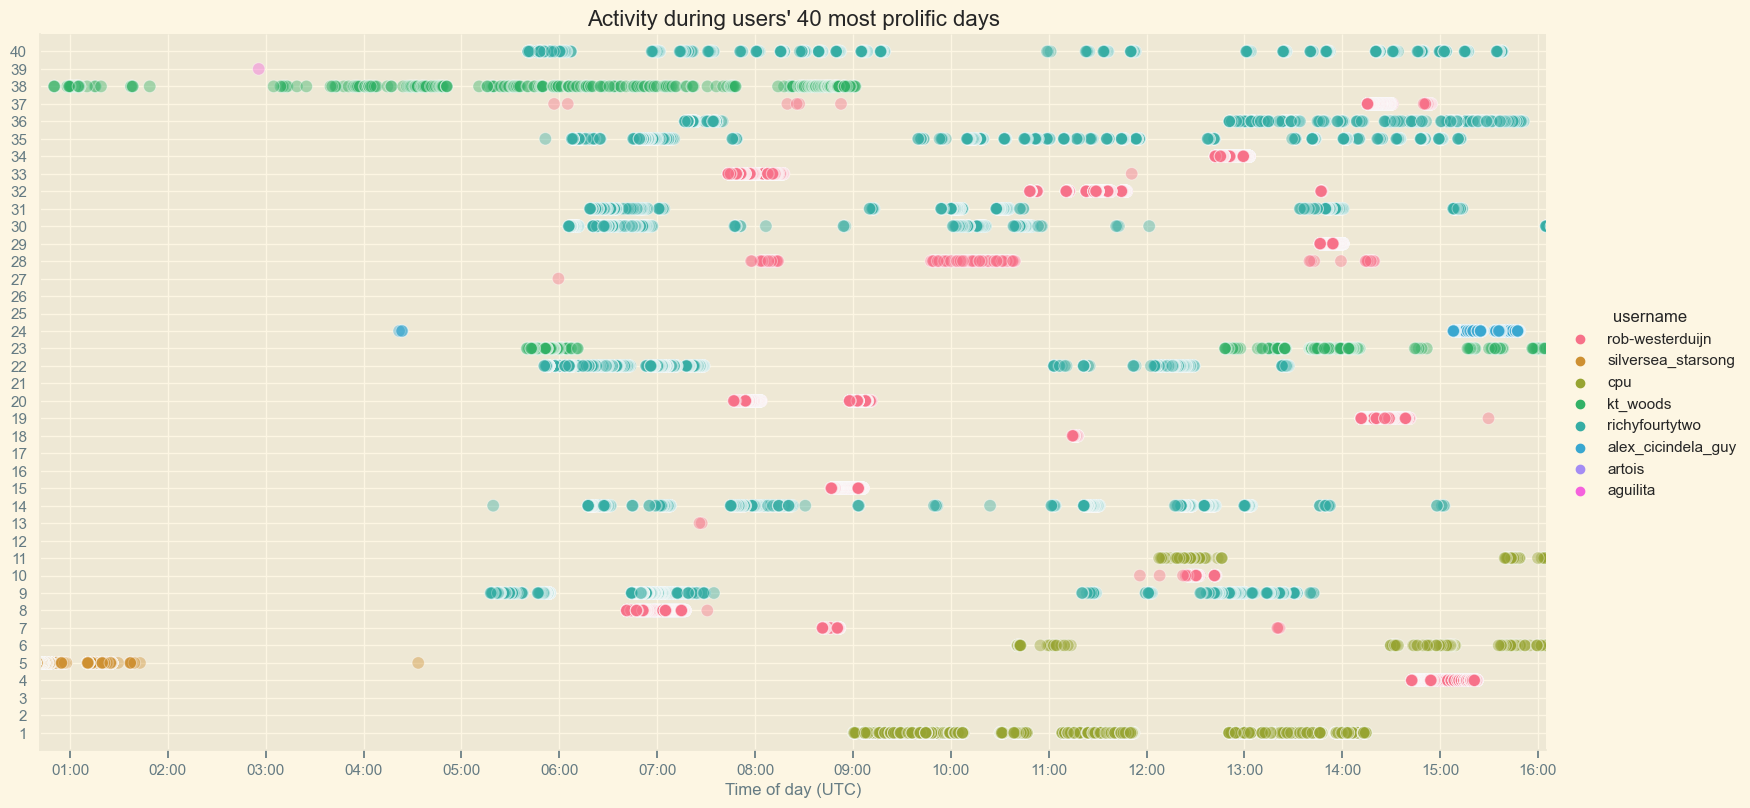

In [15]:
test = JOINED_IDS.sort_values('session_leaderboard')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)
    ax = sns.relplot(x=times_of_day, y=test['session_leaderboard'], hue=test['username'],
                       alpha=.4, s=80,
                       palette=sns.color_palette("husl", 8), legend=True, height=8, aspect=2).axes[0,0]
    ax.set(title='Activity during users\' 40 most prolific days', xlabel='Time of day (UTC)', ylabel='', 
           xlim=(times_of_day.iloc[0], times_of_day.iloc[-1]), ylim=(0,41), yticks=range(1,41))
    ax.tick_params(which="both", bottom=True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator())

# ax.figure.tight_layout()
ax.figure.savefig('top 40 days by hour.png')

In [16]:
import geopandas
import folium

ModuleNotFoundError: No module named 'folium'